<b>1. Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import re
import statistics
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn
#from scipy.stats import gaussian_kde
import scipy.stats as ss
from datetime import datetime
import statsmodels.api as sm
from statsmodels.formula.api import ols

<b> 2. Importing data 

In [2]:
customers=pd.read_csv(r"C:\Users\Blagoj\Documents\Openclassrooms\Project 5\Analyze your company's sales\updatedcustomers.csv")
products=pd.read_csv(r"C:\Users\Blagoj\Documents\Openclassrooms\Project 5\Analyze your company's sales\updatedproducts.csv")
transactions=pd.read_csv(r"C:\Users\Blagoj\Documents\Openclassrooms\Project 5\Analyze your company's sales\final.csv").drop(columns=['Unnamed: 0'])

<b> 3. Indicators of central tendency and dispersion <b>

In [3]:
#The idea is to add a month/year column and check some central indicators regarding it.
#Converting the date column to datetime type. This is necessary for the next step.
transactions.loc[:, 'date'] = pd.to_datetime(transactions['date'])
#Addind a 'month_year' column to the dataframe which we will use in our analysis.
transactions.loc[transactions['date'].dt.to_period('M').index, ['month_year']] = transactions['date'].dt.to_period('M')
#Creating a simple dataframe showing the sum of all transactions for each month.
monthly=transactions.groupby('month_year').sum().drop(columns=['birth', 'categ'])
#Renaming column
monthly=monthly.rename(columns={'price':'revenue'})
#Manual calculations of some central tendency indicators. The reason for this is to show that
#I understand the steps instead of simply using the existing functions
mean_monthly=monthly['revenue'].sum()/monthly.size
print(f"The mean monthly revenue is: {int(mean_monthly):.0f}")

def manual_median(monthly):
    sorted_revenue=sorted(monthly['revenue'])
    len_revenue=len(monthly['revenue'])
    index=(len_revenue-1)//2
    
    if (len_revenue % 2):
        return sorted_revenue[index]
    else:
        return (sorted_revenue[index] + sorted_revenue[index+1])/2.0

median_monthly=manual_median(monthly)
print(f"The median monthly revenue is: {int(median_monthly):.0f}")

The mean monthly revenue is: 483048
The median monthly revenue is: 485312


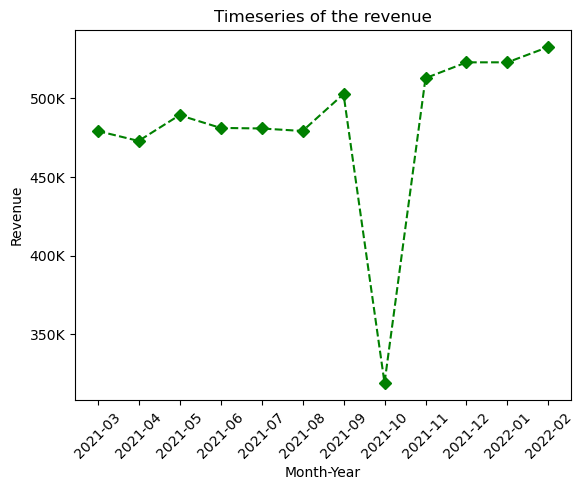

In [4]:
#Converting the type to string which is necessary for the next step
monthly.index=monthly.index.to_series().astype(str)
#Plotting the monthly revenue
plt.plot(monthly, 'g--D')
plt.ylabel('Revenue')
plt.xlabel('Month-Year')
plt.xticks(rotation=45)
plt.title('Timeseries of the revenue')
def thousands(y, pos):
    return '{:,.0f}K'.format(y*1e-3)

formatter = ticker.FuncFormatter(thousands)
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

In [5]:
#Additional central tendency. This time without manual calculations and a different example:
#Mean is the sum of the values/the count of the lines
meanavg=transactions["price"].mean()
#Median is the middle value when the prices are ordered
medianavg=transactions["price"].median()
#The mode is the value repeated the most
modeavg=transactions["price"].mode()
#The deviation is the difference between the individial value and the mean (meanavg).
#The variance which is the mean of all deviations.
#The standard deviation is the square root of the variance value.
stdev=statistics.pstdev(transactions["price"])

skewness=transactions["price"].skew()
#This means that the data has many extreme values on the right side of the distribution
#and the majority of the data is concentrated on the left side.

print(f"The mean average of the price of all transactions is: {meanavg:.2f}")
print(f"The median average of the price of all transactions is: {medianavg:.2f}")
print("The mode of the price of all transactions is: {:.2f}".format(round(float(modeavg), 2)))
print(f"The standard deviation of the price of all transactions is: {stdev:.2f}")
print(f"The skewness of the price of all transactions is: {skewness:.2f}")

The mean average of the price of all transactions is: 17.22
The median average of the price of all transactions is: 13.90
The mode of the price of all transactions is: 15.99
The standard deviation of the price of all transactions is: 17.86
The skewness of the price of all transactions is: 5.48


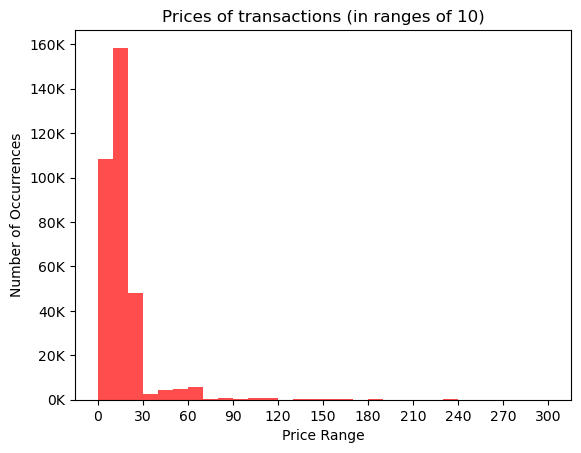

In [6]:
#Visualizing the distribution of the prices

#Plotting the histogram that groups the values in bins of 10
plt.hist(transactions['price'], bins=range(0, int(transactions['price'].max())+1, 10), alpha=0.7, color='red')

plt.xlabel("Price Range")
plt.ylabel("Number of Occurrences")
plt.title("Prices of transactions (in ranges of 10)")
plt.xticks(range(0, int(transactions['price'].max())+1, int(transactions['price'].max()/10)))

formatter = ticker.FuncFormatter(thousands)
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

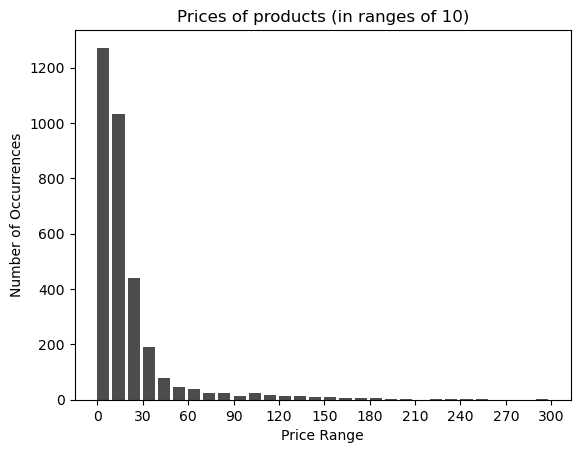

In [7]:
#Another example showing the prices of each product, just to avoid confusion with the prices of the transactions
products['price_range']=pd.cut(products['price'], bins=range(0, int(products['price'].max())+11, 10), labels=False)
products['price_range']=products['price_range'].astype(int) * 10

price_counts=products.groupby('price_range').count()

plt.bar(price_counts.index, price_counts['price'], width=8, align='edge', alpha=0.7, color='black')

plt.xlabel("Price Range")
plt.ylabel("Number of Occurrences")
plt.title("Prices of products (in ranges of 10)")
plt.xticks(range(0, int(products['price'].max())+11, 30))
plt.show()

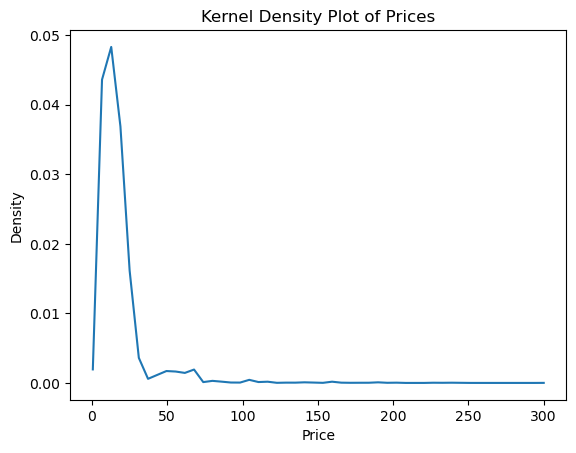

In [8]:
#Back to transactions. Alternative visualisation
import matplotlib.pyplot as plt
import numpy as np

price_col = transactions["price"].values

density = ss.gaussian_kde(price_col)
x = np.linspace(np.min(price_col), np.max(price_col), 50)

plt.plot(x, density(x))
plt.title("Kernel Density Plot of Prices")
plt.xlabel("Price")
plt.ylabel("Density")
plt.show()

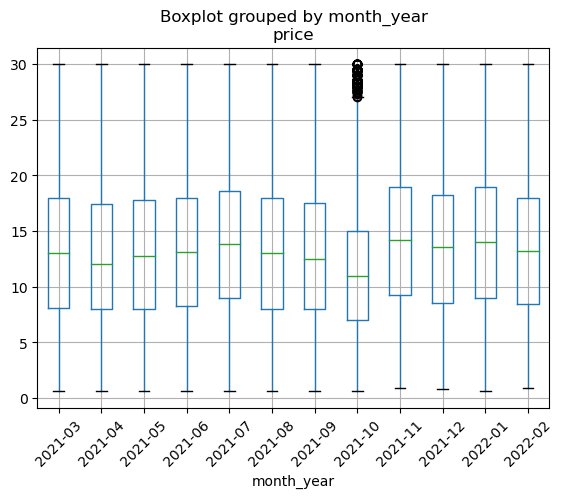

In [9]:
#From the above graphs we have seen that most of our values are between 0 and 30 so we are creating a
#boxplot that is limited on those values only so we can see the distribution per month.
lowtransactions=transactions.query('price <30') #masking
lowtransactions.boxplot(column='price', by='month_year')
plt.xticks(rotation=45)
plt.show()

In [10]:
#Dispersion - Calculating range, interquartile range, standard deviation and variance.
smallest=transactions["price"].min()
biggest=transactions["price"].max()
pricerange = transactions["price"].max() - transactions["price"].min()
first_quartile = transactions["price"].quantile(0.25)
third_quartile = transactions["price"].quantile(0.75)
IQR = third_quartile - first_quartile
std = transactions["price"].std()
variance = transactions["price"].var()
print(smallest, biggest, pricerange, first_quartile, third_quartile, IQR, std, variance)
print(f"The line with the smallest transactions is: {smallest:.2f}")
print(f"The line with the biggest transactions is: {biggest:.2f}")
print(f"Meaning that the price range is: {pricerange:.2f}")
print(f"The first quartile is: {first_quartile:.2f}")
print(f"The third quartile is: {third_quartile:.2f}")
print(f"Meaninng the interquartile range is: {IQR:.2f}")
print(f"The standard deviation is: {std:.2f}")
print(f"The variance is: {variance:.2f}")

0.62 300.0 299.38 8.61 18.99 10.379999999999999 17.855445377653435 318.81692963436547
The line with the smallest transactions is: 0.62
The line with the biggest transactions is: 300.00
Meaning that the price range is: 299.38
The first quartile is: 8.61
The third quartile is: 18.99
Meaninng the interquartile range is: 10.38
The standard deviation is: 17.86
The variance is: 318.82


<b> Concentration analysis <b>

In [11]:
#Estimating gini coefficient.
m=transactions['price'].mean()
ginimanual=(2 * m-std)/(2 * m)
print(ginimanual)

0.48140430285125785


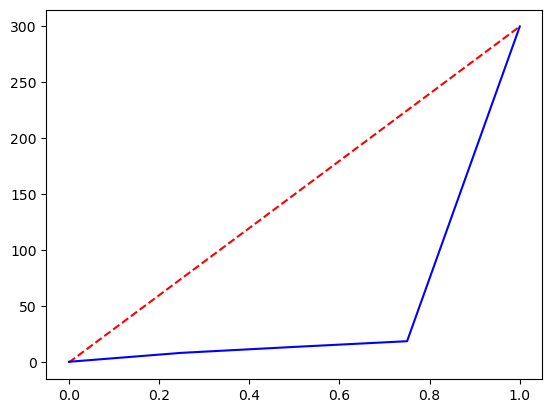

In [12]:
#First attempt at a Lorenz curve:
pricearray=transactions['price'].to_numpy()
Q0=np.percentile(pricearray,0)
Q1=np.percentile(pricearray,25)
Q2=np.percentile(pricearray,50)
Q3=np.percentile(pricearray,75)
Q4=np.percentile(pricearray,100)
percentilearray=[Q0, Q1, Q2, Q3, Q4]
printarray=[0, 75, 150, 225, 300]
lorenz=[0, 25/100, 50/100, 75/100, 100/100]
plt.plot(lorenz, printarray, 'r--')
plt.plot(lorenz, percentilearray, 'b-')
price_area2=np.trapz(printarray, lorenz)

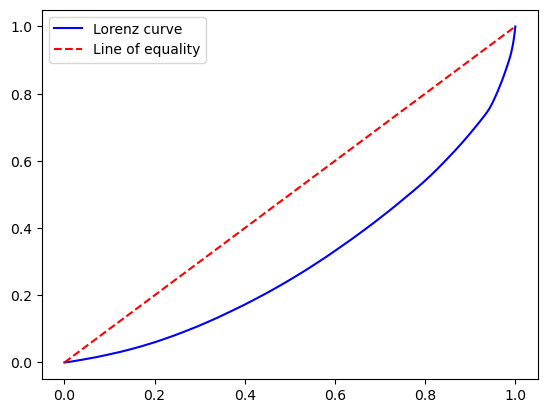

In [13]:
#More accurate Lorenz curve
data = sorted(transactions['price'])
#Defining and normalizing the cumulative sum
norm_cum_sum = np.cumsum(data) / np.cumsum(data)[-1]
    
#Defining x and y
x = np.insert(np.arange(1, len(data)+1) / len(data), 0, 0)
y = np.insert(norm_cum_sum, 0, 0)

#Plotting
plt.plot(x, y, 'b-', label='Lorenz curve')
plt.plot([0, 1], [0, 1], 'r--', label='Line of equality')
plt.legend()
plt.show()

In [14]:
#Calculating the gini coefficient
gini2=1-2*np.trapz(y, x)
gini2

0.3921455108925064

<b> Correlation between gender and categories of products purchased <b>

In [15]:
#This first example is manually calculated to show that I understand the steps.
#We are going to test whether these two categorical variables are related to each other (chi-square test of independence).

In [16]:
#Getting a quick look at our dataframe before we continue with the bivaraite analyses
transactions.head()

,id_prod,date,session_id,client_id,price,categ,_merge,sex,birth,month_year
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,4.99,0.0,both,f,1977,2021-04
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,65.75,2.0,both,f,2000,2022-02
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,10.71,1.0,both,f,1979,2021-09
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,4.20,0.0,both,m,1963,2021-10
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,8.99,0.0,both,f,1980,2021-07


In [17]:
#Changing the type of the 'categ' column
transactions['categ']=transactions['categ'].astype(str)
#Creating and displaying the contingency table
contingency=pd.crosstab(transactions['sex'], transactions['categ'])
contingency

categ,0.0,1.0,2.0
sex,,,
f,103786,55469,8260
m,105640,54266,9292


Null hypothesis (H0): Sex and category are not related in the population; 
The proportions of items that are purchased are the same for both sexes.

Alternative hypothesis (Ha): Sex and  category are related in the population; 
The proportions of items that are purchased are not the same for both sexes.

In [18]:
#Calculating the row and column totals of the contingency table.
total=contingency.sum().sum()
total0=contingency['0.0'].sum()
total1=contingency['1.0'].sum()
total2=contingency['2.0'].sum()
totalf = contingency.loc['f'].sum()
totalm = contingency.loc['m'].sum()


print(total, total0, total1, total2, totalf, totalm)

336713 209426 109735 17552 167515 169198


In [19]:
#Calculating the expected values as (row total*columntotal)/N:
first=(totalf*total0)/total
second=(totalf*total1)/total
third=(totalf*total2)/total
fourth=(totalm*total0)/total
fifth=(totalm*total1)/total
sixth=(totalm*total2)/total
print(first, second, third, fourth, fifth, sixth)

104189.61070704131 54593.25456694574 8732.134726012955 105236.38929295869 55141.74543305426 8819.865273987045


In [20]:
#Building the expected variable table in the same format
data = {
    'categ': [0.0, 1.0, 2.0, 0.0, 1.0, 2.0],
    'sex': ['f', 'f', 'f', 'm', 'm', 'm'],
    'count': [first, second, third, fourth, fifth, sixth]
}

expected = pd.DataFrame(data).pivot(index='sex', columns='categ', values='count')
expected.head()

categ,0.0,1.0,2.0
sex,,,
f,104189.610707,54593.254567,8732.134726
m,105236.389293,55141.745433,8819.865274


In [21]:
# Stacking the contingency dataframe and adding a new 'categ' column
contingency_stacked = contingency.stack().reset_index()
contingency_stacked.columns = ['sex', 'categ', 'contingency']
contingency_stacked['categ'] = contingency_stacked['categ'].astype('float64')

# Stacking the expected dataframe and adding a new 'categ' column
expected_stacked = expected.stack().reset_index()
expected_stacked.columns = ['sex', 'categ', 'expected']
expected_stacked['categ'] = expected_stacked['categ'].astype('float64')

# Merging the two dataframes on 'sex' and 'categ'
temp = pd.merge(contingency_stacked, expected_stacked, on=['sex', 'categ'])
#temporary table for calculatuiion
temp

,sex,categ,contingency,expected
0,f,0.0,103786,104189.610707
1,f,1.0,55469,54593.254567
2,f,2.0,8260,8732.134726
3,m,0.0,105640,105236.389293
4,m,1.0,54266,55141.745433
5,m,2.0,9292,8819.865274


In [22]:
#Adding a 'difference' column to the table that contains the difference between the original and expected values.
temp['difference']=temp['contingency']-temp['expected']
#Adding a 'diffsquare' column to the table containing the square of the 'difference'.
temp['diffsquare']=temp['difference']*temp['difference']
#Adding a 'ds/expected' column containing the division of 'diffsquare' and 'expected'.
temp['ds/expected']=temp['diffsquare']/temp['expected']
temp

,sex,categ,contingency,expected,difference,diffsquare,ds/expected
0,f,0.0,103786,104189.610707,-403.610707,162901.602838,1.563511
1,f,1.0,55469,54593.254567,875.745433,766930.063515,14.048074
2,f,2.0,8260,8732.134726,-472.134726,222911.199507,25.527687
3,m,0.0,105640,105236.389293,403.610707,162901.602838,1.547959
4,m,1.0,54266,55141.745433,-875.745433,766930.063515,13.908339
5,m,2.0,9292,8819.865274,472.134726,222911.199507,25.273765


In [23]:
#Calculating the chi_square value
chi_square=temp['ds/expected'].sum()
chi_square

81.86933350990711

In [24]:
#calculating the degrees of freedom and the critical value.
df=(2-1)*(3-1)
signiflevel=0.05
crit_value=ss.chi2.ppf(1-signiflevel, df)
crit_value

5.991464547107979

Since the chi_square value (81.87) is bigger than the critical value (5.99) we conclude that the difference is statistically significant. This data allows us to reject the null hypothesis that the variables are unrelated, concluding that there is a correlation between gender and categories of products purchased.

In [25]:
#We could calculate all of the above with a one liner:
chi2, p, df, expected = ss.chi2_contingency(contingency)

# Print the results
print("Chi-squared statistic:", chi2)
print("p-value: {:.5f}".format(p))
print("Degrees of freedom:", df)
print("Expected values:", expected)

Chi-squared statistic: 81.86933350990711
p-value: 0.00000
Degrees of freedom: 2
Expected values: [[104189.61070704  54593.25456695   8732.13472601]
 [105236.38929296  55141.74543305   8819.86527399]]


Here we can see the p-value being less than 0.0001 which helps us deny the null hypothesis.

<b> Correlation between age and total amount of purchases <b>

In [26]:
#Calculating and adding an 'age' column
transactions['age']=(datetime.now().year - transactions['birth'])
#Grouping by session_id to show transactions instead of lines.
session_grouped=transactions.groupby('session_id').agg({'price': 'sum', 'age': 'first', 'month_year': 'first', 'sex': 'first'})
#Grouping by total amount
totalam_grouped = session_grouped.groupby('age')['price'].count().reset_index()
#Calculating Pearson's coefficient
r = np.corrcoef(totalam_grouped['age'], totalam_grouped['price'])[0, 1]
print(f"Pearson's correlation coefficient between age and total number of purchases is: {r:.2f} indicating that there is a correlation between the 2 variables")

Pearson's correlation coefficient between age and total number of purchases is: -0.55 indicating that there is a correlation between the 2 variables


Text(0, 0.5, 'Number of purchases')

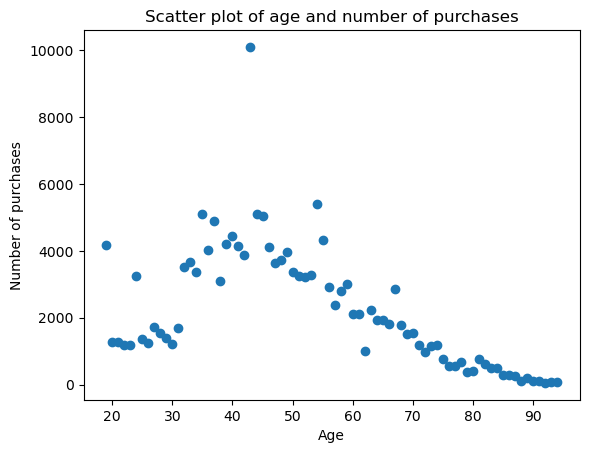

In [27]:
#A graph to double check my correlation coefficient
plt.scatter(totalam_grouped['age'], totalam_grouped['price'])
plt.title("Scatter plot of age and number of purchases")
plt.xlabel("Age")
plt.ylabel("Number of purchases")

<b> Correlation between age and the purchase frequency (the number of purchases per month for example) <b>

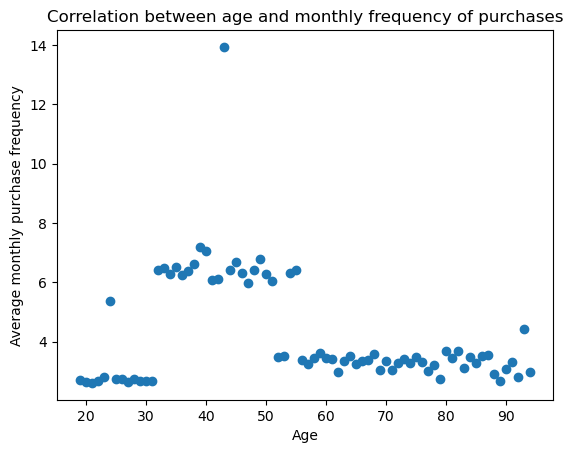

Pearson's correlation coefficient between age and frequency of purchases is: -0.29


In [29]:
#Grouping transactions by client_id and month_year, and calculate purchase count for each group
grouped = transactions.groupby(['client_id', 'month_year']).size().reset_index(name='purchase_count')
age_df = transactions.groupby('client_id')['age'].mean().reset_index(name='age')
#Grouping by age and calculating average purchase frequency
grouped_age = grouped.merge(age_df, on='client_id').groupby('age')['purchase_count'].agg(['sum', 'count'])
grouped_age['avg_freq'] = grouped_age['sum'] / grouped_age['count']

# Ploting a scatter plot
plt.scatter(grouped_age.index, grouped_age['avg_freq'])
plt.title(f"Correlation between age and monthly frequency of purchases")
plt.xlabel("Age")
plt.ylabel("Average monthly purchase frequency")
plt.show()

# Calculating Pearson's coefficient
r = np.corrcoef(grouped_age.index, grouped_age['avg_freq'])[0, 1]
print(f"Pearson's correlation coefficient between age and frequency of purchases is: {r:.2f}")

grouped_age_month=transactions.groupby(['age', 'month_year']).size().reset_index(name='count')
grouped_age = grouped_age_month.groupby('age')['count'].agg(['sum', 'count'])
grouped_age['avg_freq'] = grouped_age['sum'] / grouped_age['count']
plt.scatter(grouped_age.index, grouped_age['avg_freq'])
plt.title(f"Correlation between age and monthly frequency of purchases")
plt.xlabel("Age")
plt.ylabel("Average monthly purchase frequency")
plt.show()
r = np.corrcoef(grouped_age.index, grouped_age['avg_freq'])[0, 1]
print(f"Pearson's correlation coefficient between age and frequency of purchases is: {r:.2f}")

<b> Correlation between age and the average basket size (in number of items) <b>

Pearson's correlation coefficient between age and total purchases is: -0.58


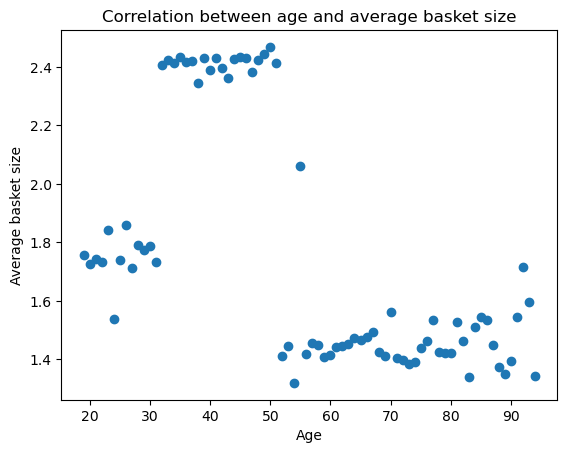

In [31]:
#age_grouped = transactions.groupby('age')['price'].sum().reset_index()
session_item_counts = transactions.groupby(['age', 'session_id'])['id_prod'].count().reset_index()
avg_basket_size = session_item_counts.groupby('age')['id_prod'].mean().to_frame().reset_index()
avg_basket_size.columns = ['age','avg_basket_size']
rcoef = np.corrcoef(avg_basket_size['age'], avg_basket_size['avg_basket_size'])[0, 1]
print(f"Pearson's correlation coefficient between age and total purchases is: {rcoef:.2f}")
plt.scatter(avg_basket_size['age'], avg_basket_size['avg_basket_size'])
plt.title(f"Correlation between age and average basket size")
plt.xlabel("Age")
plt.ylabel("Average basket size")
plt.show()

<b> Correlation between age and categories of purchased products <b>

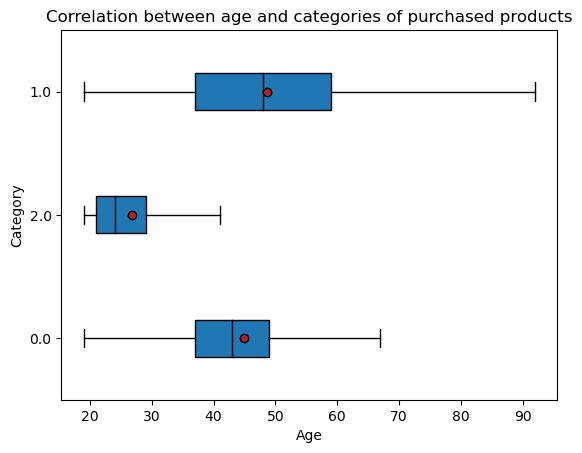

In [33]:
X = transactions['categ']
Y = transactions['age']

categories = X.unique()
groups = []
for m in categories:
    groups.append(Y[X == m])

medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

plt.boxplot(np.array(groups, dtype=object), labels=categories, showfliers=False, medianprops=medianprops,
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title(f"Correlation between age and categories of purchased products")
plt.xlabel("Age")
plt.ylabel("Category")
plt.show()

In [34]:
data = transactions[['categ', 'age']]
avg_age = data.groupby('categ')['age'].mean()
print(avg_age)

categ
0.0    44.897720
1.0    48.659124
2.0    26.728179
Name: age, dtype: float64


In [36]:
f_statistic, p_value = ss.f_oneway(data[data['categ']=="0.0"]['age'], 
                                      data[data['categ']=="1.0"]['age'], 
                                      data[data['categ']=="2.0"]['age'])

print(f_statistic, p_value)

22711.788769000035 0.0
